In [23]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
quandl.ApiConfig.api_key = 'bULWv51MebBBGL56KGys'

## Fetch Data

##### We will analyze stocks with historically high volatility and large trading volumes, such as large tech companies. Start and end dates were chosen based on availability of options data.

In [24]:
start = '2015-01-01'
end = '2020-12-31'

tickers = ['GOOG', 'AMZN', 'SNAP', 'MSFT', 'FB', 'TSLA', 'NVDA', 'JPM', 'AVGO', 'VZ']

##### Historical adjusted close prices

In [25]:
adj_close = quandl.get_table("QUOTEMEDIA/PRICES", 
                        ticker = tickers,  
                        qopts = { 'columns': ['ticker', 'date', 'adj_close']},  
                        date = { 'gte': start, 'lte': end}, 
                        paginate = True)

In [26]:
adj_close

,ticker,date,adj_close
None,,,
0,VZ,2020-12-31,55.537089
1,VZ,2020-12-30,54.960449
2,VZ,2020-12-29,55.593808
3,VZ,2020-12-28,55.754511
4,VZ,2020-12-24,55.622167
...,...,...,...
14561,AMZN,2015-01-08,300.460000
14562,AMZN,2015-01-07,298.420000
14563,AMZN,2015-01-06,295.290000


##### Financial statement filing date

In [27]:
# earnings dates (FC/FILING_DATE)
zacks_fc = quandl.get_table('ZACKS/FC', 
                    per_end_date = { 'gte': start, 'lte': end },
                    ticker = tickers, 
                    paginate=True)

In [34]:
# quarterly report filing dates
filing_dates = zacks_fc[zacks_fc['per_type'] == 'Q'][['ticker', 'filing_date']]
filing_dates

,ticker,filing_date
None,,
6,AMZN,2015-04-24
7,AMZN,2015-07-24
8,AMZN,2015-10-23
9,AMZN,2016-01-29
10,AMZN,2016-04-29
...,...,...
292,VZ,2020-02-21
293,VZ,2020-04-27
294,VZ,2020-07-28


##### Historical option data

Historical options data is sourced from the WRDS dataset "OptionMetrics - Option Prices".

In [29]:
# this is limited to options with expiry less than 8 days from current date.
option_data = pd.read_csv('data/OptionMetrics.csv.gz', sep = ',')

In [30]:
# match date format of quandl data
option_data['date'] = option_data.apply(lambda row: row.date.replace('/', '-', 2), axis = 1)
option_data['exdate'] = option_data.apply(lambda row: row.exdate.replace('/', '-', 2), axis = 1)

In [32]:
# strike_price = strike * 1000
option_data

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0,0.919228,0.986198,0.000899,1.508328,-36.45721,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,2,0.955372,0.975301,0.001419,2.475758,-61.95087,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0,0.695843,0.992689,0.000682,0.864939,-16.05143,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0,0.771536,0.978447,0.001567,2.201530,-44.71402,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0,0.673865,0.981649,0.001565,1.925056,-34.15807,106134400,AMZN,0,AMAZON.COM INC.,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538404,2020-12-30,2020-12-31,P,64000,14.55,14.70,0,0,NaN,NaN,NaN,NaN,NaN,137663387,SNAP,0,SNAP INC,A
2538405,2020-12-30,2020-12-31,P,65000,15.55,15.70,0,1,NaN,NaN,NaN,NaN,NaN,137439703,SNAP,0,SNAP INC,A
2538406,2020-12-30,2020-12-31,P,66000,16.55,16.85,0,0,2.638148,-0.979169,0.007363,0.129699,-62.33575,137663388,SNAP,0,SNAP INC,A
2538407,2020-12-30,2020-12-31,P,67000,17.55,17.75,0,0,NaN,NaN,NaN,NaN,NaN,137663389,SNAP,0,SNAP INC,A


## High-level Data Analysis

In [33]:
# create rolling realized vol from adj_close df

close_volatility = pd.DataFrame() 

for t in adj_close.ticker.unique():
    df = adj_close[adj_close['ticker'] == t]
    df = df['adj_close'].rolling(7).std() * np.sqrt(252) / 100
    close_volatility = pd.concat([close_volatility, df], axis = 0)
    

close_volatility = close_volatility.rename(columns = {0: "vola_1wk"})
close_volatility = pd.concat([adj_close, close_volatility], axis = 1)
close_volatility

,ticker,date,adj_close,vola_1wk
0,VZ,2020-12-31,55.537089,NaN
1,VZ,2020-12-30,54.960449,NaN
2,VZ,2020-12-29,55.593808,NaN
3,VZ,2020-12-28,55.754511,NaN
4,VZ,2020-12-24,55.622167,NaN
...,...,...,...,...
14561,AMZN,2015-01-08,300.460000,0.700056
14562,AMZN,2015-01-07,298.420000,0.724128
14563,AMZN,2015-01-06,295.290000,0.488910
14564,AMZN,2015-01-05,302.190000,0.580311


In [36]:
amzn_options = pd.DataFrame(option_data[option_data['ticker'] == 'AMZN'])

In [21]:
# does not account for weekends and holidays
entry_dates = pd.to_datetime(filing_dates['filing_date']) - datetime.timedelta(days=1)
exit_dates = pd.to_datetime(filing_dates['filing_date']) + datetime.timedelta(days=1)

In [51]:
# compare realized vol on day before filing_date to vol of short dated straddle

In [12]:
# graph of price moves after earnings 

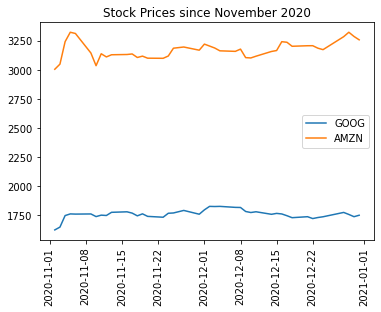

In [59]:
for stock in ['GOOG', 'AMZN']:
    df = adj_close[adj_close['ticker'] == stock]
    df = df[df['date'] > '2020-11-01']
    plt.plot(df['date'], df['adj_close'], label = stock)
plt.legend()
plt.title('Stock Prices since November 2020')
plt.xticks(rotation = 90)
plt.savefig('GOOG_AMZN.png',bbox_inches ="tight", pad_inches = 0.5, facecolor ="w")
plt.show()

In [58]:
df[df['date'] > '2020-01-08']

,ticker,date,adj_close
None,,,
2478,AMZN,2020-12-31,3256.93
2479,AMZN,2020-12-30,3285.85
2480,AMZN,2020-12-29,3322.00
2481,AMZN,2020-12-28,3283.96
2482,AMZN,2020-12-24,3172.69
...,...,...,...
2721,AMZN,2020-01-15,1862.02
2722,AMZN,2020-01-14,1869.44
2723,AMZN,2020-01-13,1891.30
